# Árboles de Regresion Entrenamiento

In [88]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

Como siempre, realizamos los cambios necesarios para poder trabajar con los datos que nos interesan:

In [89]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip", sep=",")

sotavento_columns = [col for col in wind_ava.columns if ".13" in col]
sotavento_columns.insert(0, "datetime")
sotavento_columns.append("energy")
wind_ava_sotavento = wind_ava[sotavento_columns]

wind_ava_sotavento = wind_ava_sotavento.rename(columns = {
    "energy": "Energy", 
    "datetime": "Datetime", 
    "p54.162.13": "Vertical integral of temperature", 
    "p55.162.13": "Vertical integral of water vapour", 
    "cape.13": "Convective available potential energy", 
    "p59.162.13": "Vertical integral of divergence of kinetic energy", 
    "lai_lv.13": "Leaf area index, low vegetation", 
    "lai_hv.13": "Leaf area index, high vegetation", 
    "u10n.13": "Neutral wind at 10 m u-component", 
    "v10n.13": "Neutral wind at 10 m v-component", 
    "sp.13": "Surface pressure",
    "stl1.13": "Soil temperature level 1",
    "u10.13": "10 metre U wind component",
    "v10.13": "10 metre V wind component",
    "t2m.13": "2 metre temperature", 
    "stl2.13": "Soil temperature level 2", 
    "stl3.13": "Soil temperature level 3", 
    "iews.13": "Instantaneous eastward turbulent surface stress",
    "inss.13": "Instantaneous northward turbulent surface", 
    "stl4.13": "Soil temperature level 4", 
    "fsr.13": "Forecast surface roughness", 
    "flsr.13": "Forecast logarithm of surface roughness for heat",
    "u100.13": "100 metre U wind component",
    "v100.13": "100 metre V wind component", })

wind_ava_sotavento["Datetime"] = pd.to_datetime(wind_ava_sotavento["Datetime"])
wind_ava_sotavento.dtypes

Datetime                                             datetime64[ns]
Vertical integral of temperature                            float64
Vertical integral of water vapour                           float64
Convective available potential energy                       float64
Vertical integral of divergence of kinetic energy           float64
Leaf area index, low vegetation                             float64
Leaf area index, high vegetation                            float64
Neutral wind at 10 m u-component                            float64
Neutral wind at 10 m v-component                            float64
Surface pressure                                            float64
Soil temperature level 1                                    float64
10 metre U wind component                                   float64
10 metre V wind component                                   float64
2 metre temperature                                         float64
Soil temperature level 2                        

In [90]:
duplicate_rows = wind_ava_sotavento[wind_ava_sotavento.duplicated()]
print("Número de filas duplicadas: ", duplicate_rows.shape)
null_rows = wind_ava_sotavento[wind_ava_sotavento.isnull().any(axis=1)]
print("Número de filas nulas: ", null_rows.shape)

Número de filas duplicadas:  (0, 24)
Número de filas nulas:  (0, 24)


Definimos el train y test:

In [91]:
import copy

# Dividir la columna 'Datetime' en dos nuevas columnas: 'fecha' y 'año'
wind_ava_sotavento['Month'] = wind_ava_sotavento['Datetime'].dt.month
wind_ava_sotavento['Year'] = wind_ava_sotavento['Datetime'].dt.year

# Eliminar la columna 'Datetime'
wind_ava_sotavento.drop(columns=['Datetime'], inplace=True)
# Ordenar el DataFrame wind_ava_sotavento por 'Datetime'
wind_ava_sotavento.sort_values(by=['Year', 'Month'], inplace=True)
# Crear una copia profunda del DataFrame wind_ava_sotavento
dataset_1 = copy.deepcopy(wind_ava_sotavento)
# Eliminar la columna 'Energy' de dataset_1
del dataset_1['Energy']
# Crear una copia profunda del DataFrame wind_ava_sotavento
dataset_3 = copy.deepcopy(wind_ava_sotavento)
dataset_2 = dataset_3["Energy"]
dataset_1.info()
dataset_2.info()

x_train, x_test, y_train, y_test = train_test_split(dataset_1, dataset_2, test_size=0.33, random_state=42)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Vertical integral of temperature                   4748 non-null   float64
 1   Vertical integral of water vapour                  4748 non-null   float64
 2   Convective available potential energy              4748 non-null   float64
 3   Vertical integral of divergence of kinetic energy  4748 non-null   float64
 4   Leaf area index, low vegetation                    4748 non-null   float64
 5   Leaf area index, high vegetation                   4748 non-null   float64
 6   Neutral wind at 10 m u-component                   4748 non-null   float64
 7   Neutral wind at 10 m v-component                   4748 non-null   float64
 8   Surface pressure                                   4748 non-null   float64
 9   Soil tem

# Evaluación con hiperparámetros por omisión

In [92]:
x_train, x_test, y_train, y_test = train_test_split(dataset_1, dataset_2, test_size=0.33, random_state=42)

# Creamos la clase de árbol de regresión
t_inicio = time.time()

regr = tree.DecisionTreeRegressor()

regr.fit(x_train,y_train) # Se entrena el modelo
accuracy_train_og = regr.score(x_test, y_test)  # Se obtiene el resultado de aciertos
t_fin = time.time()

print('El modelo Tree Regressor con hiperparámetros por omisión ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_og))

# Miramos sus errores
prediction = regr.predict(x_test)
error_rmse_og = sqrt(mean_squared_error(y_test, prediction))
error_mae_og = mean_absolute_error(y_test, prediction)
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_og, error_mae_og))
t_og = t_fin - t_inicio
print('El tiempo de ejecucion ha sido de {}'.format(t_og))

El modelo Tree Regressor con hiperparámetros por omisión ha obtenido una media de resultado de 0.42
Como errores:
	RMSE	= 506.22364654096356
	MAE	= 355.086362476069
El tiempo de ejecucion ha sido de 0.09136533737182617


Observación de los resultados:

# Análisis de Escalados

Planteamos de dos formas la posible elección de escalado:
- Una evalación de DecissionTreeRegressor por método de escalado
- Pipeline

1. Una evalación de DecissionTreeRegressor por método de escalado

# MinMax

In [93]:
# Escalamos con MinMax de un rango entre 0 y 1
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
x_train_minmax = scaler_minmax.fit_transform(x_train)
x_test_minmax = scaler_minmax.transform(x_test)

# Entrenamos el modelo
t_inicio = time.time() # Guardamos el tiempo inicial
regr = tree.DecisionTreeRegressor()
np.random.seed(42)  # Para la toma de decisión entre varios puntos
regr.fit(x_train_minmax,y_train) # Se entrena el modelo
accuracy_train_minmax = regr.score(x_test_minmax, y_test)  # Se obtiene el resultado de aciertos
t_fin = time.time() # Guardamos el tiempo final
print('El modelo Tree Regressor con escalado MinMax ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_minmax))
# Miramos sus errores
prediction = regr.predict(x_test)
error_rmse_minmax = sqrt(mean_squared_error(y_test, prediction))
error_mae_minmax = mean_absolute_error(y_test, prediction)
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_minmax, error_mae_minmax))
t_minmax = t_fin - t_inicio
print('El tiempo de ejecucion ha sido de {}'.format(t_minmax))

El modelo Tree Regressor con escalado MinMax ha obtenido una media de resultado de 0.44
Como errores:
	RMSE	= 1282.4002426026414
	MAE	= 1035.1375877472879
El tiempo de ejecucion ha sido de 0.08980727195739746


c:\Users\aitan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


# Estandarización

In [94]:
# Escalamos con estandarización
scaler_standard = StandardScaler()
x_train_standard = scaler_standard.fit_transform(x_train)
x_test_standard = scaler_standard.transform(x_test)

# Entrenamos el modelo
t_inicio = time.time() # Guardamos el tiempo inicial
regr = tree.DecisionTreeRegressor()
np.random.seed(42)  # Para la toma de decisión entre varios puntos
regr.fit(x_train_standard,y_train) # Se entrena el modelo
accuracy_train_standard= regr.score(x_test_standard, y_test)  # Se obtiene el resultado de aciertos
t_fin = time.time() # Guardamos el tiempo final
print('El modelo Tree Regressor con escalado estándar ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_standard))
# Miramos sus errores
prediction = regr.predict(x_test)
error_rmse_standard = sqrt(mean_squared_error(y_test, prediction))
error_mae_standard = mean_absolute_error(y_test, prediction)
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_standard, error_mae_standard))
t_standard = t_fin - t_inicio
print('El tiempo de ejecucion ha sido de {}'.format(t_standard))

El modelo Tree Regressor con escalado estándar ha obtenido una media de resultado de 0.44
Como errores:
	RMSE	= 1146.9599514541724
	MAE	= 938.1385513720484
El tiempo de ejecucion ha sido de 0.09071660041809082


c:\Users\aitan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


# Robusto

In [95]:
# Escalamos con escalado robusto
scaler_robust = RobustScaler()
x_train_robust = scaler_robust.fit_transform(x_train)
x_test_robust = scaler_robust.transform(x_test)

# Entrenamos el modelo
t_inicio = time.time() # Guardamos el tiempo inicial
regr = tree.DecisionTreeRegressor()
np.random.seed(42)  # Para la toma de decisión entre varios puntos
regr.fit(x_train_robust,y_train) # Se entrena el modelo
accuracy_train_robust= regr.score(x_test_robust, y_test)  # Se obtiene el resultado de aciertos
t_fin = time.time() # Guardamos el tiempo final
print('El modelo Tree Regressor con escalado robusto ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_robust))
# Miramos sus errores
prediction = regr.predict(x_test)
error_rmse_robust = sqrt(mean_squared_error(y_test, prediction))
error_mae_robust = mean_absolute_error(y_test, prediction)
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_robust, error_mae_robust))
t_robust = t_fin - t_inicio
print('El tiempo de ejecucion ha sido de {}'.format(t_robust))

El modelo Tree Regressor con escalado robusto ha obtenido una media de resultado de 0.44
Como errores:
	RMSE	= 1204.4260368200044
	MAE	= 985.9001978302488
El tiempo de ejecucion ha sido de 0.1236567497253418


c:\Users\aitan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Observación de datos al completo:

In [96]:
print('El modelo Tree Regressor con hiperparámetros por omisión ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_og))
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_og, error_mae_og))
print('El tiempo de ejecucion  con hiperparámetros por omisión ha sido de {}'.format(t_og))
print("")
print('El modelo Tree Regressor con escalado MinMax ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_minmax))
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_minmax, error_mae_minmax))
print('El tiempo de ejecucion  con escalado MinMax ha sido de {}'.format(t_minmax))
print("")
print('El modelo Tree Regressor con escalado estándar ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_standard))
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_standard, error_mae_standard))
print('El tiempo de ejecucion  on escalado estándar ha sido de {}'.format(t_standard))
print("")
print('El modelo Tree Regressor con escalado robusto ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_robust))
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_robust, error_mae_robust))
print('El tiempo de ejecucion  con escalado robusto ha sido de {}'.format(t_robust))

El modelo Tree Regressor con hiperparámetros por omisión ha obtenido una media de resultado de 0.42
Como errores:
	RMSE	= 506.22364654096356
	MAE	= 355.086362476069
El tiempo de ejecucion  con hiperparámetros por omisión ha sido de 0.09136533737182617

El modelo Tree Regressor con escalado MinMax ha obtenido una media de resultado de 0.44
Como errores:
	RMSE	= 1282.4002426026414
	MAE	= 1035.1375877472879
El tiempo de ejecucion  con escalado MinMax ha sido de 0.08980727195739746

El modelo Tree Regressor con escalado estándar ha obtenido una media de resultado de 0.44
Como errores:
	RMSE	= 1146.9599514541724
	MAE	= 938.1385513720484
El tiempo de ejecucion  on escalado estándar ha sido de 0.09071660041809082

El modelo Tree Regressor con escalado robusto ha obtenido una media de resultado de 0.44
Como errores:
	RMSE	= 1204.4260368200044
	MAE	= 985.9001978302488
El tiempo de ejecucion  con escalado robusto ha sido de 0.1236567497253418


2. Evalucion con Pipeline

Ademas ya nos devuelve la profundidad con la que podriamos trabajar.

In [97]:
# Definir el pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor())
])

# Definir el grid de parámetros
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'regressor__max_depth': [3, 5, 6, 9]
}

# Definir la división de series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda en la grilla con la división de series temporales
grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros: ", grid_search.best_params_)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones
y_pred = best_model.predict(x_test)

# Calcular e imprimir la métrica de rendimiento (RMSE)
print("RMSE: ", sqrt(mean_squared_error(y_test, y_pred)))

Mejores parámetros:  {'regressor__max_depth': 5, 'scaler': RobustScaler()}
RMSE:  425.64383488314513


Vamos a realizar los estudios de otra forma un poco más gráfica para que se vea más claro todo:

In [98]:
posible_depth = [1, 2, 3, 4, 5, 6, None]
errors_rmse_depth = []
errors_mae_depth = []
scores_depth = []
times_depth = []

# Probamos con las diferentes profundidaes
for max_depth in posible_depth:
  # Entrenamos el modelo
  t_inicio = time.time() # Guardamos el tiempo inicial
  regr = tree.DecisionTreeRegressor(max_depth = max_depth)

  regr.fit(x_train,y_train) # Se entrena el modelo
  accuracy_train_max_depth= regr.score(x_test, y_test)  # Se obtiene el resultado de aciertos
  t_fin = time.time() # Guardamos el tiempo final
  # Miramos sus errores
  prediction = regr.predict(x_test)
  error_rmse_max_depth = sqrt(mean_squared_error(y_test, prediction))
  error_mae_max_depth = mean_absolute_error(y_test, prediction)
  time_max_depth = t_fin-t_inicio
  #Añadimos los resultados a nuestras listas
  errors_rmse_depth.append(error_rmse_max_depth)
  errors_mae_depth.append(error_mae_max_depth)
  scores_depth.append(accuracy_train_max_depth)
  times_depth.append(time_max_depth)

In [99]:
index = scores_depth.index(max(scores_depth))
print('Mayor score (max_depth = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_depth[index], index, scores_depth[index], errors_rmse_depth[index], errors_mae_depth[index], times_depth[index]))
index = errors_rmse_depth.index(min(errors_rmse_depth))
print('Menor rmse (max_depth = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_depth[index], index, scores_depth[index], errors_rmse_depth[index], errors_mae_depth[index], times_depth[index]))
index = errors_mae_depth.index(min(errors_mae_depth))
print('Menor mae (max_depth = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_depth[index], index, scores_depth[index], errors_rmse_depth[index], errors_mae_depth[index], times_depth[index]))
index = times_depth.index(min(times_depth))
print('Menor tiempo (max_depth = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_depth[index], index, scores_depth[index], errors_rmse_depth[index], errors_mae_depth[index], times_depth[index]))

Mayor score (max_depth = 6 ; index = 5):
	Score	= 0.5964539694898632
	RMSE	= 421.93825206182515
	MAE	= 304.0323080782675
	Time	= 0.036339759826660156
Menor rmse (max_depth = 6 ; index = 5):
	Score	= 0.5964539694898632
	RMSE	= 421.93825206182515
	MAE	= 304.0323080782675
	Time	= 0.036339759826660156
Menor mae (max_depth = 6 ; index = 5):
	Score	= 0.5964539694898632
	RMSE	= 421.93825206182515
	MAE	= 304.0323080782675
	Time	= 0.036339759826660156
Menor tiempo (max_depth = 1 ; index = 0):
	Score	= 0.2901745407802633
	RMSE	= 559.6005666662326
	MAE	= 449.16756764057124
	Time	= 0.011177301406860352


Observamos que con una profundidad máxima de 6 todo estaría perfecto.

Ahora necesitamos definir el número adecuado de muestras, tal que:

In [100]:
posible_samples = range(0,300,5)
errors_rmse_samples = []
errors_mae_samples = []
scores_samples = []
times_samples = []

# Probamos con las diferentes números
for min_samples in posible_samples:
  if min_samples == 0:
    min_samples = 2  
  # Entrenamos el modelo
  t_inicio = time.time() # Guardamos el tiempo inicial
  regr = tree.DecisionTreeRegressor(min_samples_split = min_samples)

  regr.fit(x_train,y_train) # Se entrena el modelo
  accuracy_train_min_samples= regr.score(x_test, y_test)  # Se obtiene el resultado de aciertos
  t_fin = time.time() # Guardamos el tiempo final
  # Miramos sus errores
  prediction = regr.predict(x_test)
  error_rmse_min_samples = sqrt(mean_squared_error(y_test, prediction))
  error_mae_min_samples = mean_absolute_error(y_test, prediction)
  time_min_samples = t_fin - t_inicio
  #Añadimos los resultados a nuestras listas
  errors_rmse_samples.append(error_rmse_min_samples)
  errors_mae_samples.append(error_mae_min_samples)
  scores_samples.append(accuracy_train_min_samples)
  times_samples.append(time_min_samples)
  

In [101]:
index = scores_samples.index(max(scores_samples))
print('Mayor score (min_samples = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_samples[index], index, scores_samples[index], errors_rmse_samples[index], errors_mae_samples[index], times_samples[index]))
index = errors_rmse_samples.index(min(errors_rmse_samples))
print('Menor rmse (min_samples = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_samples[index], index, scores_samples[index], errors_rmse_samples[index], errors_mae_samples[index], times_samples[index]))
index = errors_mae_samples.index(min(errors_mae_samples))
print('Menor mae (min_samples = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_samples[index], index, scores_samples[index], errors_rmse_samples[index], errors_mae_samples[index], times_samples[index]))
index = times_samples.index(min(times_samples))
print('Menor tiempo (min_samples = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_samples[index], index, scores_samples[index], errors_rmse_samples[index], errors_mae_samples[index], times_samples[index]))

Mayor score (min_samples = 180 ; index = 36):
	Score	= 0.6315800372512748
	RMSE	= 403.15675109727295
	MAE	= 292.87404194530126
	Time	= 0.04605388641357422
Menor rmse (min_samples = 180 ; index = 36):
	Score	= 0.6315800372512748
	RMSE	= 403.15675109727295
	MAE	= 292.87404194530126
	Time	= 0.04605388641357422
Menor mae (min_samples = 140 ; index = 28):
	Score	= 0.6285259273447613
	RMSE	= 404.8243368854992
	MAE	= 291.5037122162846
	Time	= 0.05170893669128418
Menor tiempo (min_samples = 265 ; index = 53):
	Score	= 0.6239228084821655
	RMSE	= 407.32480384022296
	MAE	= 295.4677302599913
	Time	= 0.041639089584350586


Representación gráfica de los errores:

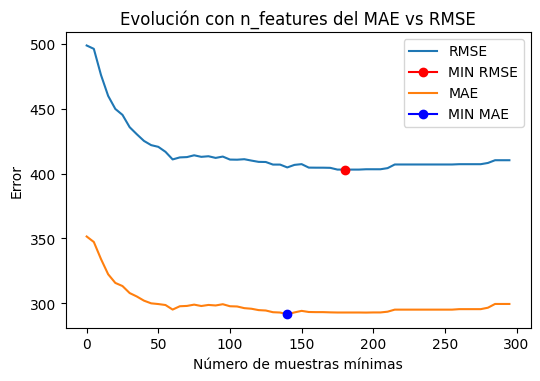

In [102]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(posible_samples, errors_rmse_samples, label="RMSE")
ax.plot(posible_samples[errors_rmse_samples.index(min(errors_rmse_samples))], min(errors_rmse_samples),
        marker='o', color = "red", label="MIN RMSE")
ax.plot(posible_samples, errors_mae_samples, label="MAE")
ax.plot(posible_samples[errors_mae_samples.index(min(errors_mae_samples))], min(errors_mae_samples),
        marker='o', color = "blue", label="MIN MAE")
ax.set_xlabel("Número de muestras mínimas")
ax.set_ylabel("Error")
ax.set_title("Evolución con n_features del MAE vs RMSE")
plt.legend();

Finalmente, nos centraremos en las impurezas:

In [103]:
posible_imp = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
errors_rmse_imp = []
errors_mae_imp = []
scores_imp = []
times_imp = []

# Probamos con las diferentes números
for min_impurity in posible_imp:
  # Entrenamos el modelo
  t_inicio = time.time() # Guardamos el tiempo inicial
  regr = tree.DecisionTreeRegressor(min_impurity_decrease=min_impurity)
  np.random.seed(42)  # Para la toma de decisión entre varios puntos
  regr.fit(x_train,y_train) # Se entrena el modelo
  accuracy_train_min_impurity= regr.score(x_test, y_test)  # Se obtiene el resultado de aciertos
  t_fin = time.time() # Guardamos el tiempo final
  # Miramos sus errores
  prediction = regr.predict(x_test)
  error_rmse_min_impurity = sqrt(mean_squared_error(y_test, prediction))
  error_mae_min_impurity = mean_absolute_error(y_test, prediction)
  time_min_impurity = t_fin - t_inicio
  #Añadimos los resultados a nuestras listas
  errors_rmse_imp.append(error_rmse_min_impurity)
  errors_mae_imp.append(error_mae_min_impurity)
  scores_imp.append(accuracy_train_min_impurity)
  times_imp.append(time_min_impurity)

In [104]:
index = scores_imp.index(max(scores_imp))
print('Mayor score (min_impurity = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_imp[index], index, scores_imp[index], errors_rmse_imp[index], errors_mae_imp[index], times_imp[index]))
index = errors_rmse_imp.index(min(errors_rmse_imp))
print('Menor rmse (min_impurity = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_imp[index], index, scores_imp[index], errors_rmse_imp[index], errors_mae_imp[index], times_imp[index]))
index = errors_mae_imp.index(min(errors_mae_imp))
print('Menor mae (min_impurity = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_imp[index], index, scores_imp[index], errors_rmse_imp[index], errors_mae_imp[index], times_imp[index]))
index = times_imp.index(min(times_imp))
print('Menor tiempo (min_impurity = {} ; index = {}):\n\tScore\t= {}\n\tRMSE\t= {}\n\tMAE\t= {}\n\tTime\t= {}'.format(posible_imp[index], index, scores_imp[index], errors_rmse_imp[index], errors_mae_imp[index], times_imp[index]))

Mayor score (min_impurity = 0 ; index = 0):
	Score	= 0.4392070344657638
	RMSE	= 497.39754592994154
	MAE	= 348.86375239310786
	Time	= 0.09382224082946777
Menor rmse (min_impurity = 0 ; index = 0):
	Score	= 0.4392070344657638
	RMSE	= 497.39754592994154
	MAE	= 348.86375239310786
	Time	= 0.09382224082946777
Menor mae (min_impurity = 1.1 ; index = 11):
	Score	= 0.43507128878465295
	RMSE	= 499.2282848099913
	MAE	= 347.69734759865617
	Time	= 0.08809185028076172
Menor tiempo (min_impurity = 1.8 ; index = 18):
	Score	= 0.42410360392060287
	RMSE	= 504.05106876543834
	MAE	= 349.8281901389046
	Time	= 0.08399724960327148


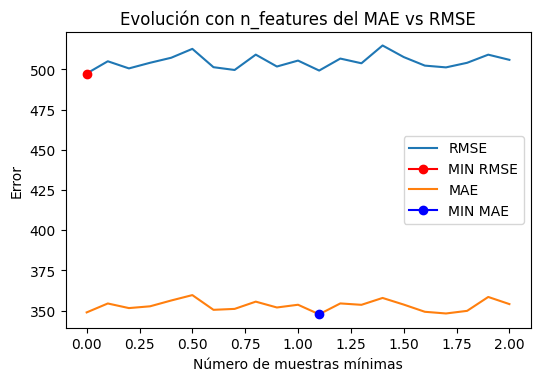

In [105]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(posible_imp, errors_rmse_imp, label="RMSE")
ax.plot(posible_imp[errors_rmse_imp.index(min(errors_rmse_imp))], min(errors_rmse_imp),
        marker='o', color = "red", label="MIN RMSE")
ax.plot(posible_imp, errors_mae_imp, label="MAE")
ax.plot(posible_imp[errors_mae_imp.index(min(errors_mae_imp))], min(errors_mae_imp),
        marker='o', color = "blue", label="MIN MAE")
ax.set_xlabel("Número de muestras mínimas")
ax.set_ylabel("Error")
ax.set_title("Evolución con n_features del MAE vs RMSE")
plt.legend();

# Hiperparámetros con Cross-Validation

In [106]:
# Vemos el neighbour mejor con GridSearchCV (cross-validation)
params = {'max_depth': [6],
          'min_samples_split': [140, 180]}

# Creamos el modelo
t_inicio = time.time() # Guardamos el tiempo inicial
regr = tree.DecisionTreeRegressor()

cv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(regr, params, cv=cv)
grid.fit(x_train, y_train)

t_fin = time.time() # Guardamos el tiempo final
print('El modelo de árbol de regresión (max_depth = {} ; min_samples_split = {}) con un resultado de {:.2f}'
      .format(grid.best_params_['max_depth'], grid.best_params_['min_samples_split'], grid.score(x_test, y_test)))
# Miramos sus errores
prediction = grid.predict(x_test)
error_rmse_grid = sqrt(mean_squared_error(y_test, prediction))
error_mae_grid = mean_absolute_error(y_test, prediction)
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_grid, error_mae_grid))
t_grid = t_fin - t_inicio
print('El tiempo de ejecucion ha sido de {}'.format(t_grid))

El modelo de árbol de regresión (max_depth = 6 ; min_samples_split = 140) con un resultado de 0.62
Como errores:
	RMSE	= 408.17255401249093
	MAE	= 299.71037332762535
El tiempo de ejecucion ha sido de 0.20832300186157227


# Conclusión

Observamos el paso de un 42% a un 62%, lo que supone una mejora bastante grande

In [107]:
# Vemos el neighbour mejor con GridSearchCV (cross-validation)
params = {'max_depth': [6],
          'min_samples_split': [140]}

# Creamos el modelo
t_inicio = time.time() # Guardamos el tiempo inicial
regr = tree.DecisionTreeRegressor()
np.random.seed(42)  # Para la toma de decisión entre varios puntos
cv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(regr, params, cv=cv)
grid.fit(x_train, y_train)
t_fin = time.time() # Guardamos el tiempo final
accuracy_train_final = grid.score(x_test, y_test)
print('El modelo de árbol de regresión con un resultado de {:.2f}'.format(accuracy_train_final))
# Miramos sus errores
prediction = grid.predict(x_test)
error_rmse_final = sqrt(mean_squared_error(y_test, prediction))
error_mae_final = mean_absolute_error(y_test, prediction)
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_final, error_mae_final))
t_final = t_fin - t_inicio
print('El tiempo de ejecucion ha sido de {}'.format(t_final))

El modelo de árbol de regresión con un resultado de 0.62
Como errores:
	RMSE	= 408.172554012491
	MAE	= 299.71037332762535
El tiempo de ejecucion ha sido de 0.15401673316955566


In [108]:
print('El modelo Tree Regressor con hiperparámetros por omisión ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_og))
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_og, error_mae_og))
print('El tiempo de ejecucion con hiperparámetros por omisión ha sido de {}'.format(t_og))
print("")
print('El modelo Tree Regressor final ha obtenido una media de resultado de {:.2f}'.format(accuracy_train_final))
print('Como errores:\n\tRMSE\t= {}\n\tMAE\t= {}'.format(error_rmse_final, error_mae_final))
print('El tiempo de ejecucion final ha sido de {}'.format(t_final))

El modelo Tree Regressor con hiperparámetros por omisión ha obtenido una media de resultado de 0.42
Como errores:
	RMSE	= 506.22364654096356
	MAE	= 355.086362476069
El tiempo de ejecucion con hiperparámetros por omisión ha sido de 0.09136533737182617

El modelo Tree Regressor final ha obtenido una media de resultado de 0.62
Como errores:
	RMSE	= 408.172554012491
	MAE	= 299.71037332762535
El tiempo de ejecucion final ha sido de 0.15401673316955566
